In [12]:
import torch as th
from active_critic.learner.active_critic_learner import ActiveCriticLearner, ACLScores
from active_critic.learner.active_critic_args import ActiveCriticLearnerArgs
from active_critic.policy.active_critic_policy import ActiveCriticPolicy
from active_critic.utils.gym_utils import make_vec_env, DummyExtractor, new_epoch_reach, sample_expert_transitions, parse_sampled_transitions
from active_critic.utils.pytorch_utils import build_tf_horizon_mask
from active_critic.utils.dataset import DatasetAC
from active_critic.policy.active_critic_policy import ActiveCriticPolicySetup, ActiveCriticPolicy
from active_critic.model_src.state_model import *
from active_critic.model_src.whole_sequence_model import WholeSequenceModel, WholeSequenceModelArgs
from active_critic.model_src.transformer import ModelSetup


from gym import Env
th.manual_seed(0)

class DummyStateModel(StateModel):
    def __init__(self, args: StateModelArgs) -> None:
        super().__init__(args)

    def forward(self, inpt):
        super().forward(inpt)
        return inpt

def make_wsm_setup(seq_len, d_output, device='cpu'):
    wsm = WholeSequenceModelArgs()
    wsm.model_setup = ModelSetup()
    seq_len = seq_len
    d_output = d_output
    wsm.model_setup.d_output = d_output
    wsm.model_setup.nhead = 1
    wsm.model_setup.d_hid = 200
    wsm.model_setup.d_model = 200
    wsm.model_setup.nlayers = 3
    wsm.model_setup.seq_len = seq_len
    wsm.model_setup.dropout = 0
    wsm.lr = 5e-4
    wsm.model_setup.device = device
    wsm.optimizer_class = th.optim.Adam
    wsm.optimizer_kwargs = {}
    return wsm

def make_acps(seq_len, extractor, new_epoch, batch_size, device, horizon):
    acps = ActiveCriticPolicySetup()
    acps.device=device
    acps.epoch_len=seq_len
    acps.extractor=extractor
    acps.new_epoch=new_epoch
    acps.opt_steps=100
    acps.inference_opt_lr = 1e-2
    acps.optimizer_class = th.optim.SGD
    acps.optimize = True
    acps.batch_size = batch_size
    acps.pred_mask = build_tf_horizon_mask(seq_len=seq_len, horizon=horizon, device=device)
    acps.opt_mask = th.ones([seq_len], device=device, dtype=bool)
    acps.opt_mask[-1] = 1
    acps.opt_goal = True
    acps.optimize_goal_emb_acts = False
    acps.goal_label_multiplier = 1
    return acps

def setup_opt_state(batch_size, seq_len, device='cpu'):
    num_cpu = 1
    env, expert = make_vec_env('reach', num_cpu, seq_len=seq_len)
    d_output = env.action_space.shape[0]
    embed_dim = 39
    lr = 5e-4

    actor_args = StateModelArgs()
    actor_args.arch = [200, env.action_space.shape[0]]
    actor_args.device = device
    actor_args.lr = lr
    actor = StateModel(args=actor_args)

    critic_args = StateModelArgs()
    critic_args.arch = [200, 1]
    critic_args.device = device
    critic_args.lr = lr
    critic = StateModel(args=critic_args)

    inv_critic_args = StateModelArgs()
    inv_critic_args.arch = [200, embed_dim + env.action_space.shape[0]]
    inv_critic_args.device = device
    inv_critic_args.lr = lr
    inv_critic = StateModel(args=inv_critic_args)

    emitter_args = StateModelArgs()
    emitter_args.arch = [200, embed_dim]
    emitter_args.device = device
    emitter_args.lr = lr
    emitter = StateModel(args=emitter_args)
    #emitter = DummyStateModel(args=emitter_args)

    predictor_args = make_wsm_setup(
    seq_len=seq_len, d_output=embed_dim, device=device)
    predictor_args.model_setup.d_hid = 200
    predictor_args.model_setup.d_model = 200
    predictor_args.model_setup.nhead = 10
    predictor = WholeSequenceModel(args=predictor_args)

    horizon = seq_len


    acps = make_acps(
        seq_len=seq_len, 
        extractor=DummyExtractor(), 
        new_epoch=new_epoch_reach, 
        device=device, 
        batch_size=batch_size,
        horizon=horizon)
    acps.clip = True
    ac = ActiveCriticPolicy(observation_space=env.observation_space, 
                            action_space=env.action_space,
                            actor=actor,
                            critic=critic,
                            predictor=predictor,
                            emitter=emitter,
                            inverse_critic=inv_critic,
                            acps=acps)
    return ac, acps, batch_size, seq_len, env, expert


def make_acl(device):
    device = device
    acla = ActiveCriticLearnerArgs()
    acla.data_path = '/home/hendrik/Documents/master_project/LokalData/WSM/'
    #acla.data_path = '/data/bing/hendrik/'
    acla.device = device
    acla.extractor = DummyExtractor()
    acla.imitation_phase = False
    acla.logname = 'autoprediction'
    acla.tboard = True
    acla.batch_size = 32
    acla.validation_episodes = 1
    acla.training_epsiodes = 1
    acla.actor_threshold = 1e-2
    acla.critic_threshold = 1e-2
    acla.predictor_threshold = 1e-2
    acla.gen_scores_threshold = 1e-1
    acla.num_cpu = acla.validation_episodes

    seq_len = 40
    ac, acps, batch_size, seq_len, env, expert= setup_opt_state(device=device, batch_size=acla.batch_size, seq_len=seq_len)
    
    acps.opt_steps = 0
    acla.val_every = 1
    acla.add_data_every = 1

    

    eval_env, expert = make_vec_env('reach', num_cpu=acla.num_cpu, seq_len=seq_len)
    acl = ActiveCriticLearner(ac_policy=ac, env=env, eval_env=eval_env, network_args_obj=acla)
    return acl, env, expert, seq_len, device


In [13]:
acl, env, expert, seq_len, device = make_acl(device='cuda')

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Sampling transitions. 1
Training Reward: tensor([[0.1795]], device='cuda:0')███████████████████████████████████████████████---| 97.5% Predicting Epsiode
Sampling transitions. 1
Training Reward: tensor([[0.0534]], device='cuda:0')███████████████████████████████████████████████---| 97.5% Predicting Epsiode
Sampling transitions. 1
/home/hendrik/Documents/master_project/LokalData/WSM/autoprediction/best_validation████████████████---| 97.5% Predicting Epsiode
Success Rate: 0.0
Reward: 0.01831069588661194
training samples: 2
Sampling transitions. 1
Training Reward: tensor([[0.0255]], device='cuda:0')███████████████████████████████████████████████---| 97.5% Predicting Epsiode


KeyboardInterrupt: 

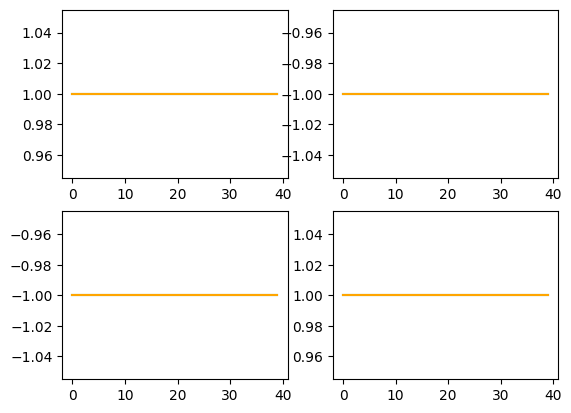

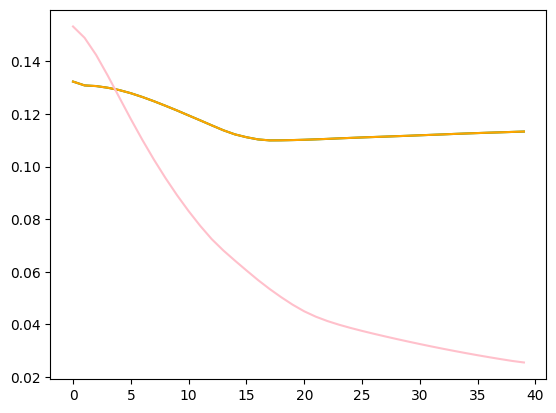

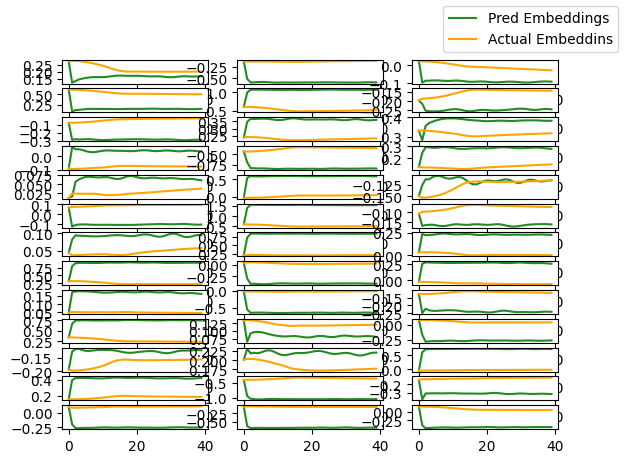

In [14]:
acl.train(20)

In [4]:
eval_env, expert = make_vec_env('reach', num_cpu=1, seq_len=10)

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [ ]:
acl.policy.reset()

In [ ]:
obs = eval_env.reset()
action = acl.policy.predict(obs)

In [ ]:
acl.policy.history.scores[0].shape

torch.Size([2, 1, 40, 40, 1])

In [ ]:
acl.policy.history.emb[0].shape

torch.Size([2, 1, 40, 40, 39])

In [ ]:
embeddings, actions = acl.policy.build_sequence(
                embeddings=acl.policy.current_embeddings, 
                actions=actions[:,:0], 
                seq_len=10, 
                goal_emb_acts=acl.policy.goal_emb_acts,
                goal_state=None,
                tf_mask=acl.policy.args_obj.pred_mask,
                actor=acl.policy.actor,
                predictor=acl.policy.predicor)

In [ ]:
actions.shape

torch.Size([1, 10, 4])

In [ ]:
acl.policy.eval()
acl.policy.reset()
seq_len = acl.policy.args_obj.epoch_len
transitions = sample_expert_transitions(
    acl.policy.predict, eval_env, 1)

In [ ]:
actions, observations, rewards = parse_sampled_transitions(
            transitions=transitions, extractor=acl.policy.args_obj.extractor, device=device)

In [ ]:
observations.shape

In [ ]:
acl.policy.history.emb[0][:,0,-1].shape

In [5]:
acl.policy.reset()
obs = eval_env.reset()
action = acl.policy.predict(obs)

In [6]:
embeddings, actions = acl.policy.build_sequence(
    embeddings=acl.policy.current_embeddings, 
    actions=None, 
    seq_len=seq_len, 
    goal_emb_acts=acl.policy.goal_emb_acts,
    goal_state=None,
    tf_mask=acl.policy.args_obj.pred_mask,
    actor=acl.policy.actor,
    predictor=acl.policy.predicor)

In [7]:
embeddings.shape

torch.Size([1, 40, 39])

In [8]:
scores = acl.policy.critic.forward(embeddings)

In [9]:
current_step = 49
predicotr_input = acl.policy.get_predictor_input(embeddings[:,:current_step], actions[:,:current_step])

In [10]:
next_states, attention = acl.policy.predicor.model.forward(src=predicotr_input, mask = acl.policy.args_obj.pred_mask[:current_step,:current_step], return_attention=True)

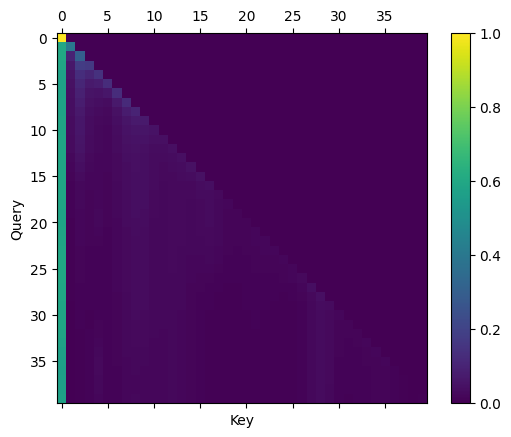

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('Query')
ax.set_xlabel('Key')
cax = ax.matshow(attention[0].to('cpu'), interpolation='nearest')
fig.colorbar(cax)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('Query')
ax.set_xlabel('Key')
cax = ax.matshow(attention[0].to('cpu'), interpolation='nearest')
fig.colorbar(cax)
plt.show()